### WARNING: Missing values are replaced with zero here. A better solution may be available-Michael is looking into the cause of the missing dates. Sue noted that this could be due to the foot-and-mouth outbreak. Don also noted that this could also be caused by traps breaking. 

This notebook explores the seasonality in the moth data and compares two appraoches to estimate the seasonal component. 

In the workshop on 19/11/2020 a rough estimate of the seasonal components were estimated using the median value for each season. First, all January values were seelcted, the median calculated and so on for all months. Then, these values were standardised so that the sum equaled 0. A problem with this is that it does not take into account any annual variation. If the yearly abundance of moths is very high in a particular year, this could affect the estimate of the seasonal components, although the effect of a high year should be damped when using the median to calculate the seasonal components. 

In this [text](https://otexts.com/fpp2/classical-decomposition.html) the seasonal components are estimated using a classical time series decomposition. The annual trend is first estimated using a [2x12ma](https://otexts.com/fpp2/moving-averages.html) moving average. This annual trend is removed from the time series, the seasonal components are then estimated from the detrended data and then standardised so that they sum to 0. This approach is the solution to a point raised by Pete about detrending and estimating the seasonality. 

In [2]:
source("R/helper.R")
options(repr.plot.width = 27, repr.plot.height = 15)

Parsed with column specification:
cols(
  IM_SPEC = col_double(),
  DESC_LATIN = col_character(),
  DESC_COMMON = col_character(),
  IM_GROUP = col_character()
)

Parsed with column specification:
cols(
  IM_SPEC = col_character(),
  DESC_LATIN = col_character(),
  DESC_COMMON = col_character(),
  IM_GROUP = col_character()
)



# Load the data and check for missing dates

In [3]:
moth = inputData(
    list(dataset='moth',
         site = 'T08', 
         daterange= c("1950-01-01","2021-01-01"),
         avg_missing_data = TRUE,
         plotPredOpt = NA  # either groups (G,M,N,O) or species (`list_interesting_moth %>% distinct(DESC_COMMON)`)
        )) %>%
    dplyr::arrange(DATETIME)
check_alldates(moth)
head(moth)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'year(DATETIME)' (override with `.groups` argument)



[1] "check_alldates: assuming dates are recorded same day each month"
[1] "missing dates:" "FALSE"         


[1] FALSE

DATETIME,counts
<date>,<dbl>
1992-10-01,2
1992-11-01,11
1992-12-01,0
1993-01-01,0
1993-02-01,3
1993-03-01,21


# Add the missing dates (!with 0's)

In [4]:
moth_full <- infill_missingdates_0(moth)

Joining, by = "DATETIME"



# Add a yearmonth column for feasts plots

In [5]:
moth_full <- moth_full %>% 
    dplyr::mutate(yearmonth = tsibble::yearmonth(moth_full$DATETIME))

# Seasonal subseries plot (grouped by month) https://otexts.com/fpp2/seasonal-plots.html. The "counts" are clearly time sensitive, with high values observed in the summer months.

Using `yearmonth` as index variable.



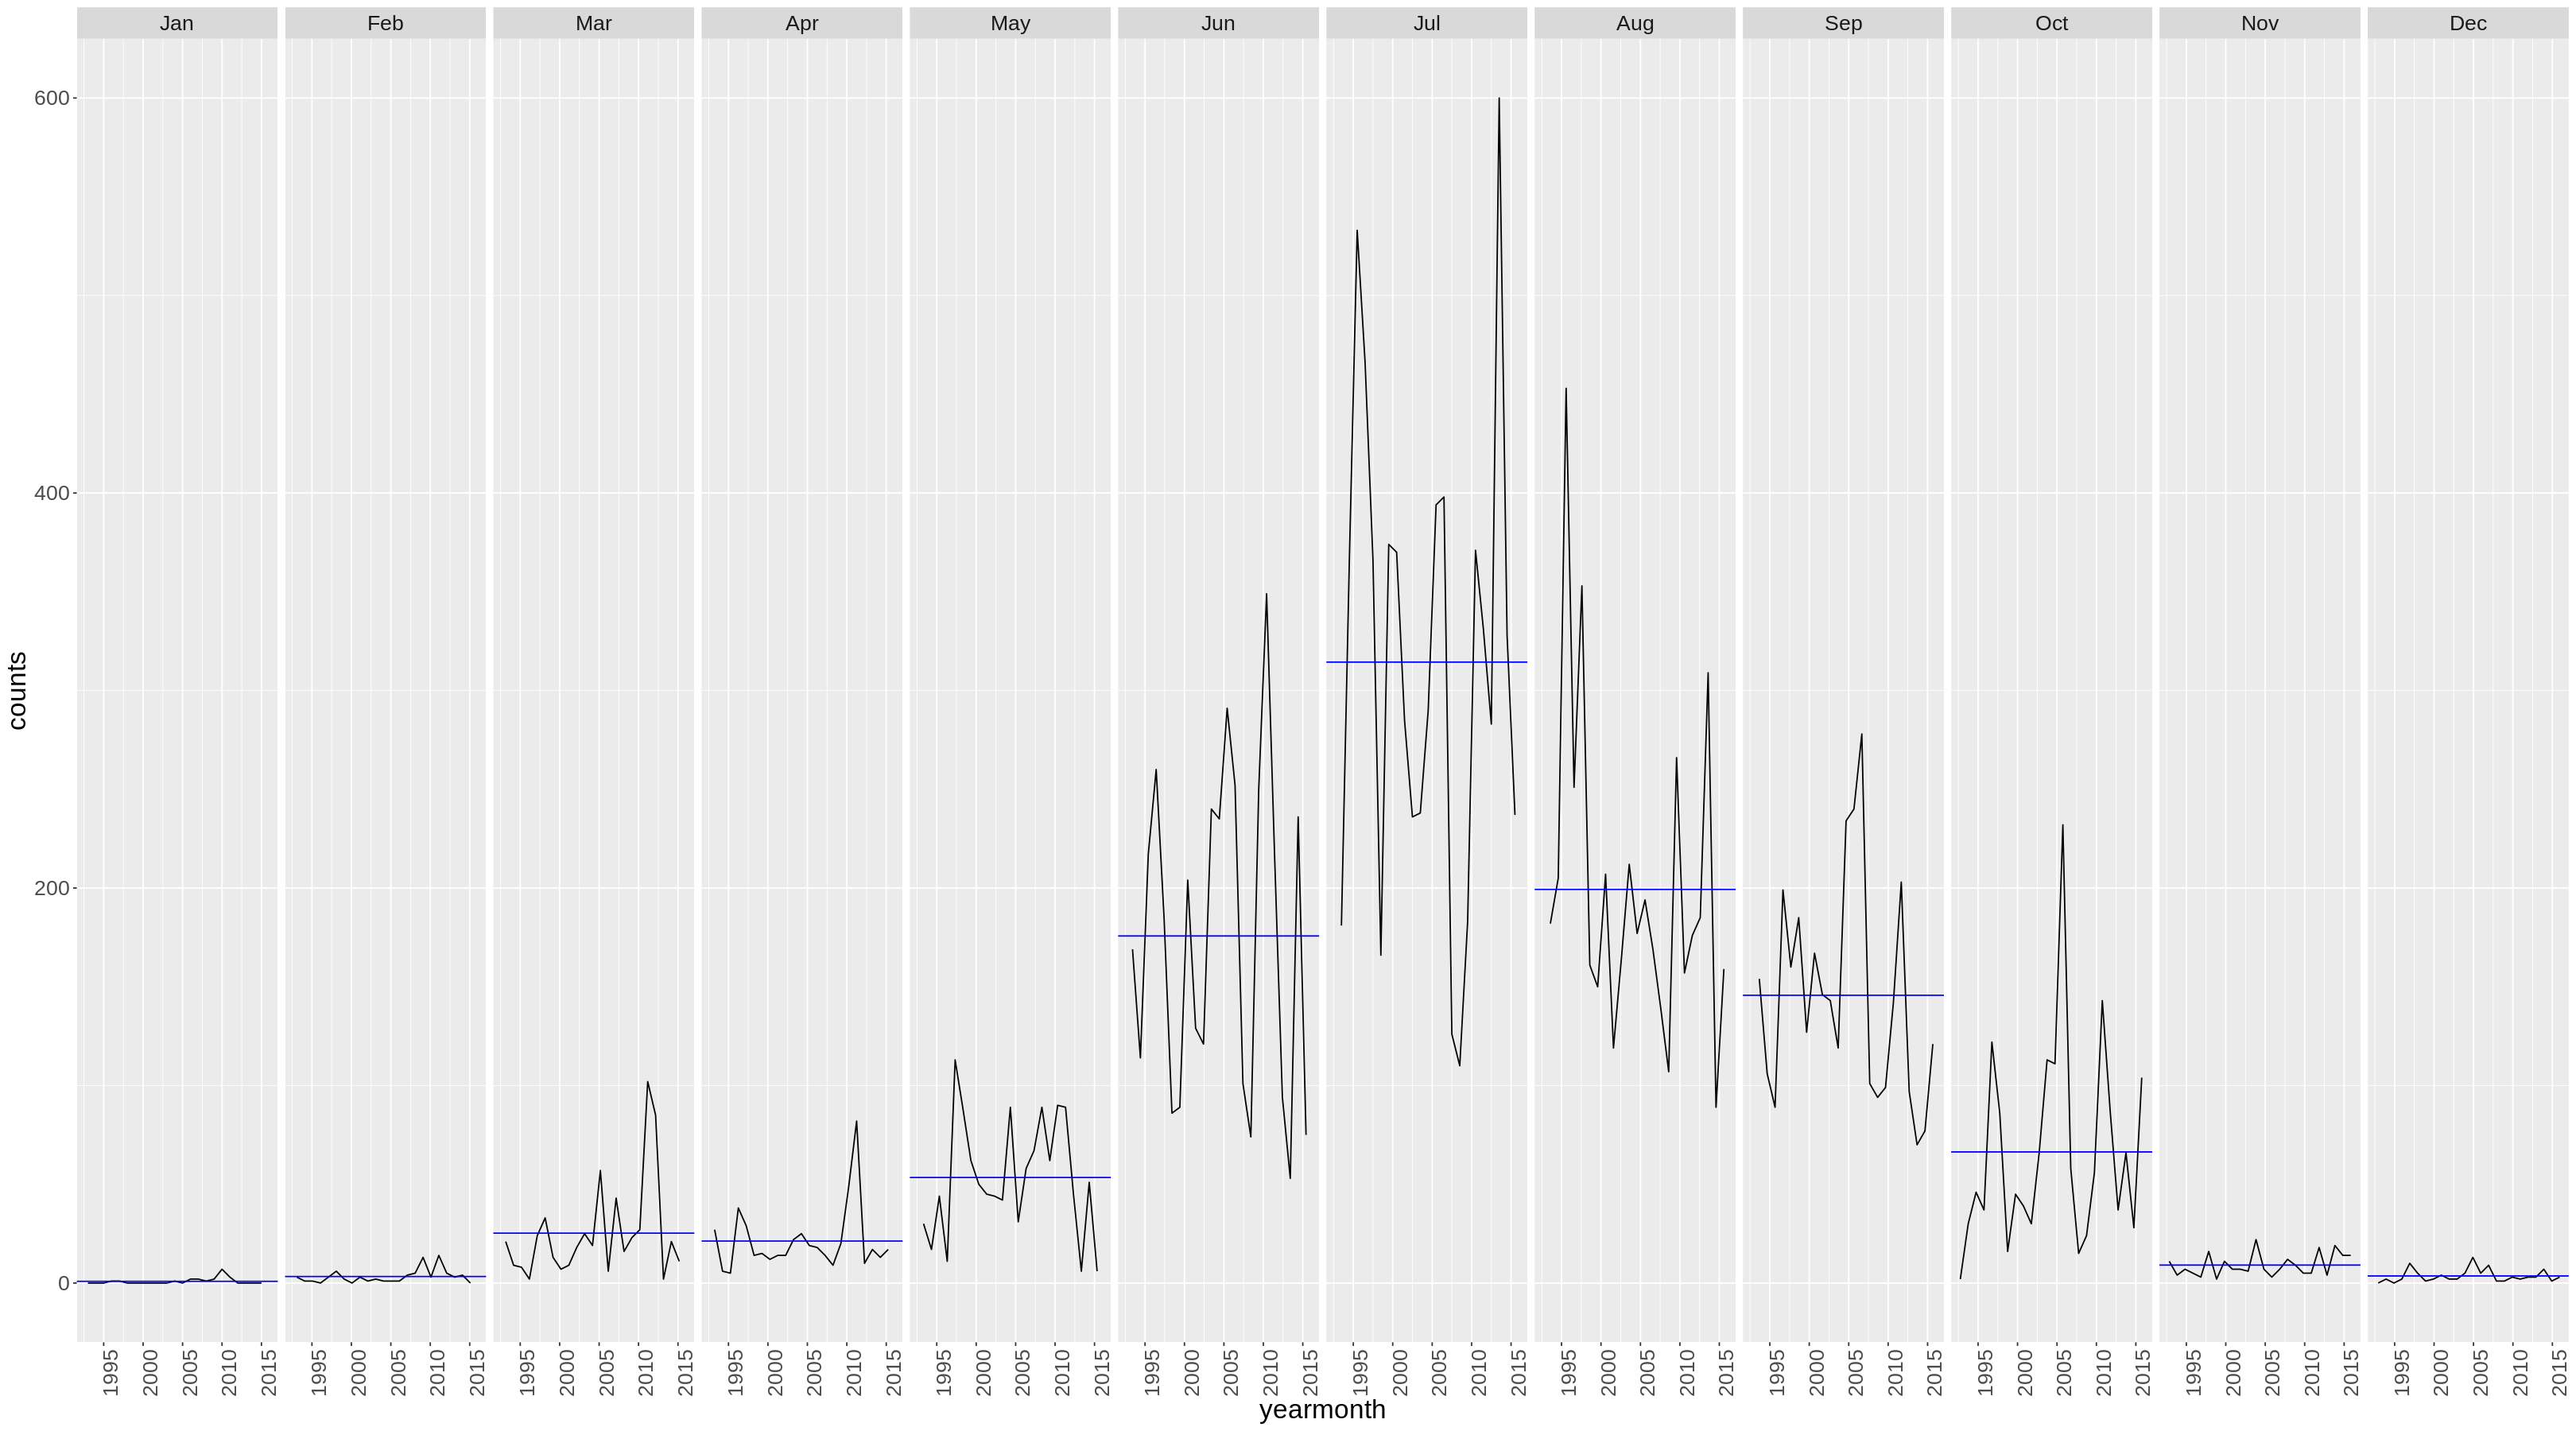

In [6]:
moth_full %>% 
    dplyr::select(yearmonth, counts) %>% 
    tsibble::as_tsibble() %>%
    feasts::gg_subseries(y=counts) + 
    theme(text = element_text(size = 20))

# Seasonal plot (grouped by year). It may be more informative if there were not so many years. 

Using `yearmonth` as index variable.



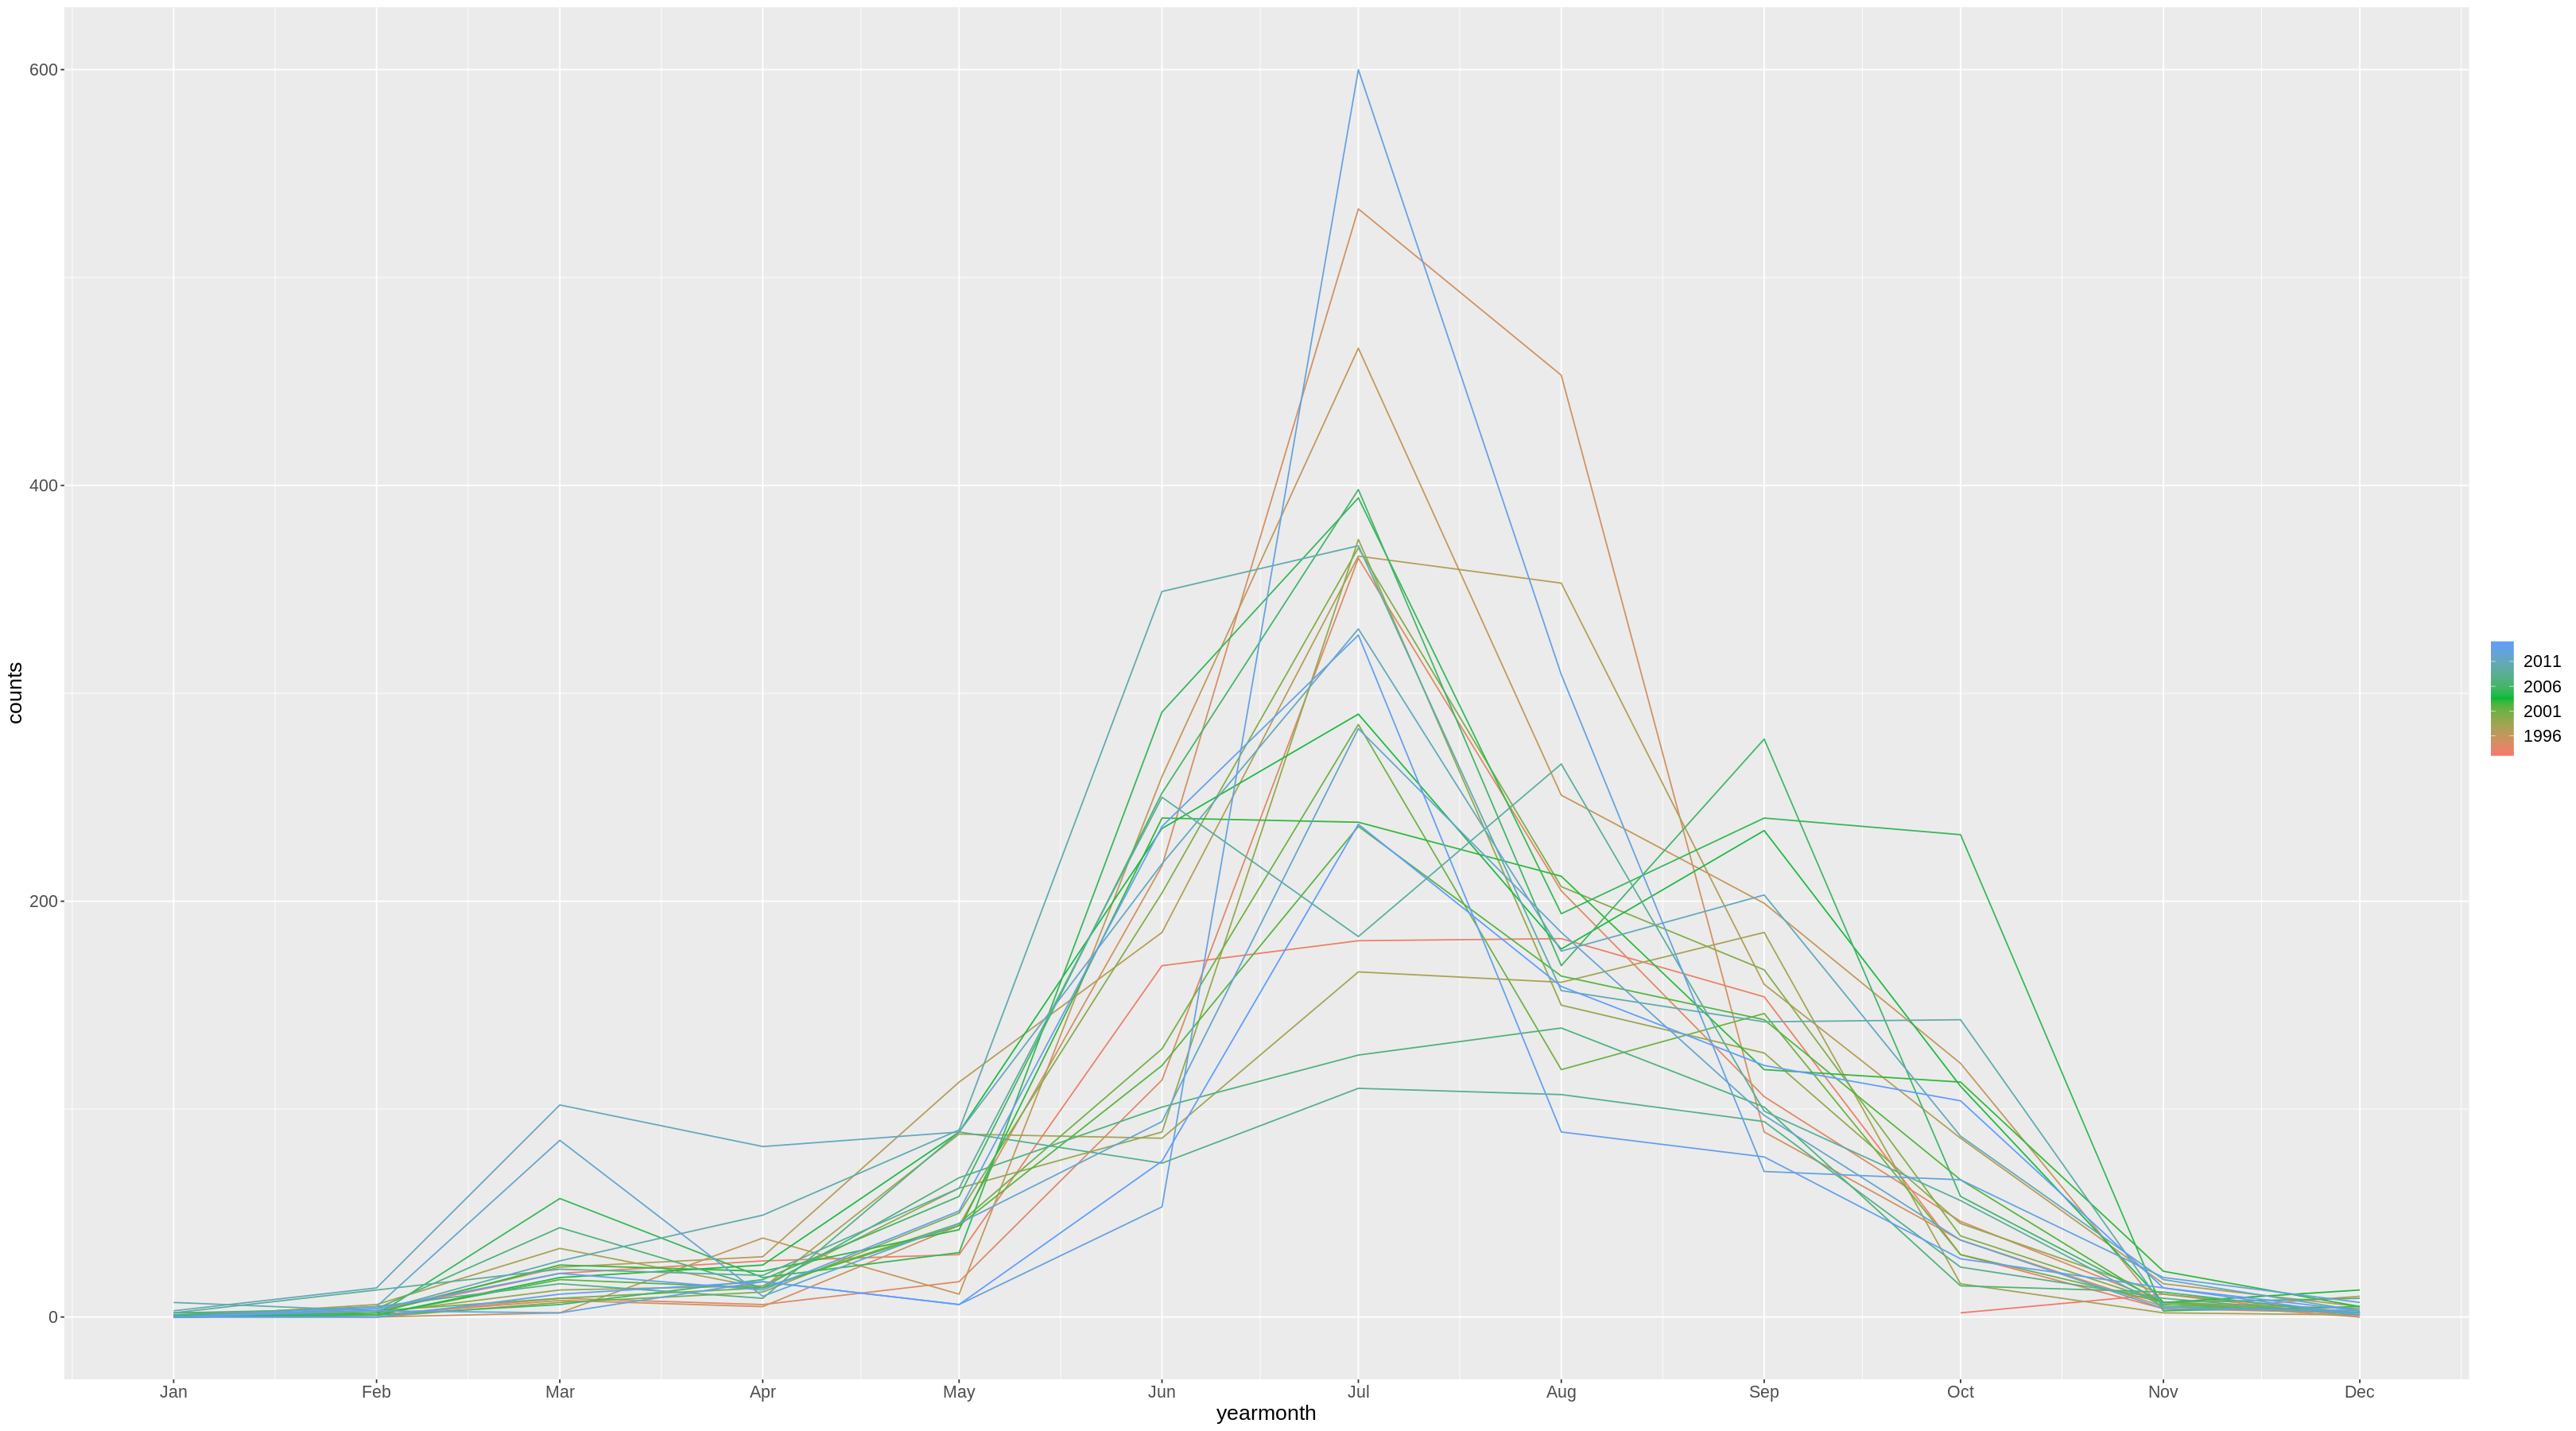

In [7]:
moth_full %>% 
    dplyr::select(yearmonth, counts) %>% 
    tsibble::as_tsibble() %>%
    feasts::gg_season(y=counts,
                     pal=(scales::hue_pal())(3)) + 
    theme(text = element_text(size = 16))

# My alternative. Overlays the feasts::gg_subseries. This will highlight if a "high" year is observed in all months. 

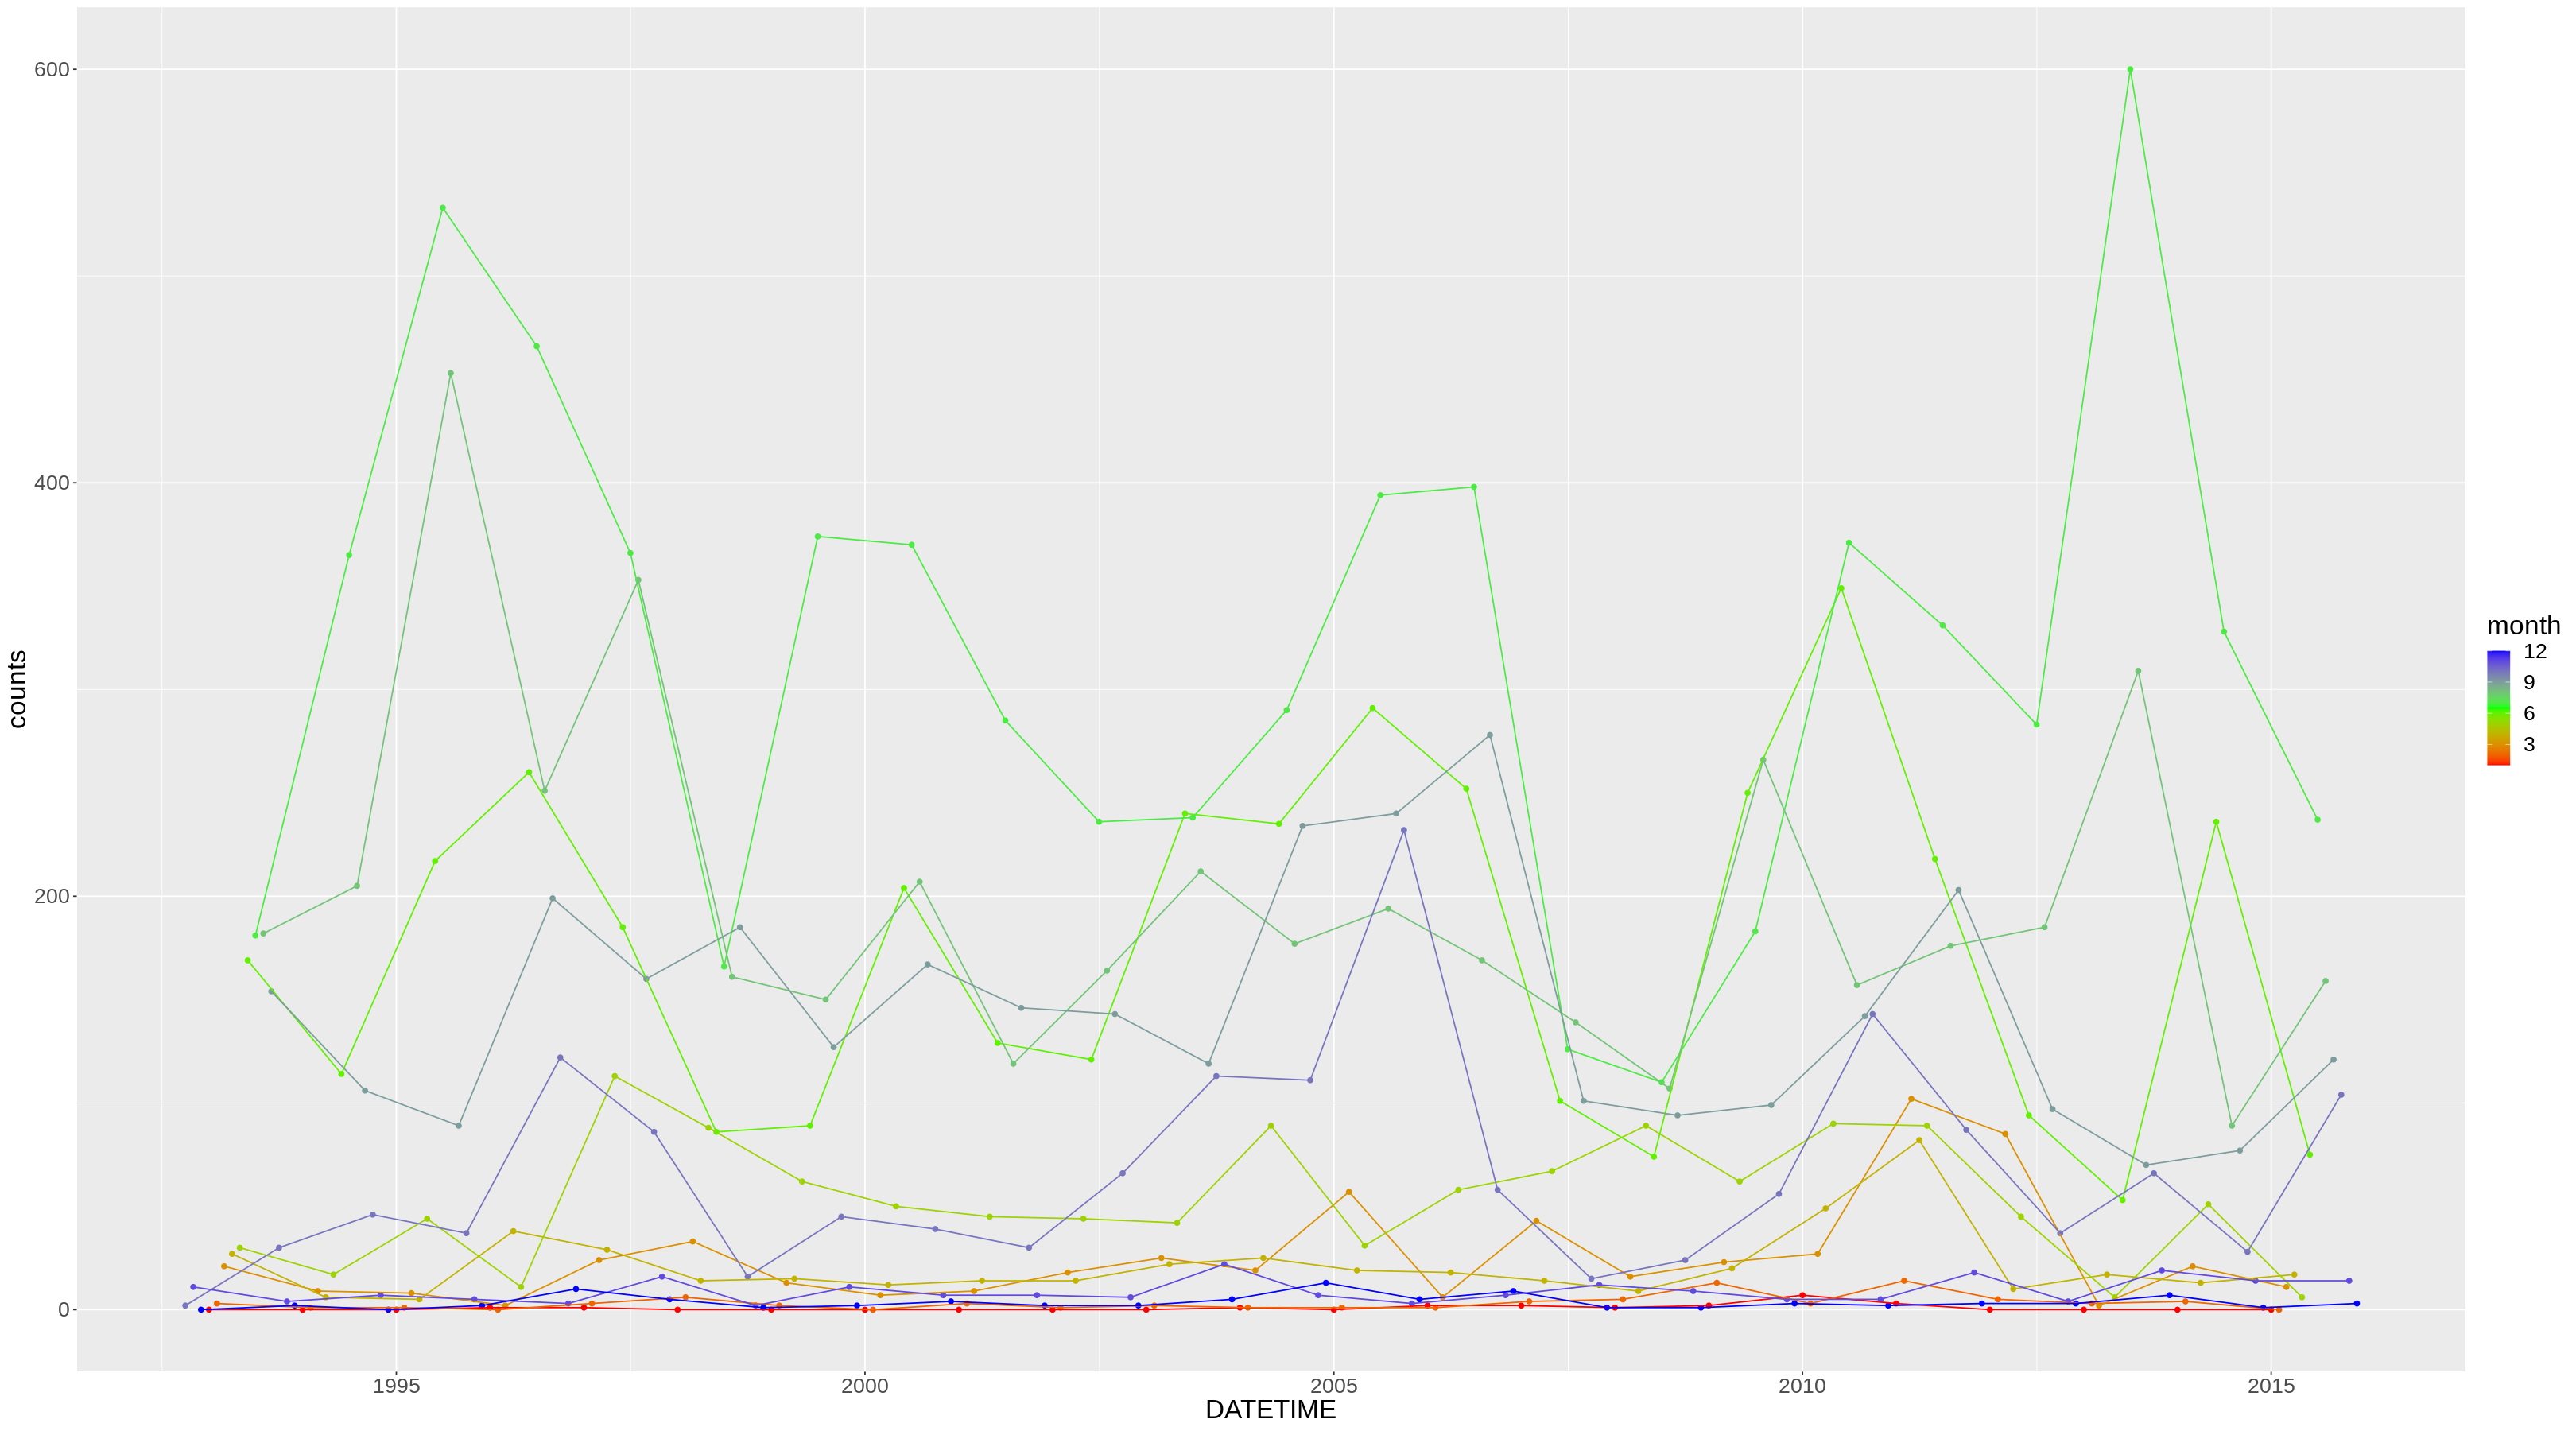

In [8]:
moth_full <- add_month(moth_full)
    
ggplot2::ggplot(moth_full, aes(x = DATETIME, y = counts, group=month, color=month) ) +
    geom_point() +
    geom_line() +
    scale_color_gradientn(colours = rainbow(3)) + 
theme(text = element_text(size = 20))

# Deseasonalise time series with median method 

In [9]:
moth_full <- add_median_deseason(moth_full)
head( moth_full, 14 )

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "month"



,DATETIME,counts,yearmonth,month,median_seas_comp,median_std_seas_comp,deseason
,<date>,<dbl>,<mth>,<dbl>,<dbl>,<dbl>,<dbl>
1,1992-10-01,2,1992 Oct,10,51.0,-30.79167,32.79167
2,1992-11-01,11,1992 Nov,11,7.0,-74.79167,85.79167
3,1992-12-01,0,1992 Dec,12,2.5,-79.29167,79.29167
4,1993-01-01,0,1993 Jan,1,0.0,-81.79167,81.79167
5,1993-02-01,3,1993 Feb,2,3.0,-78.79167,81.79167
6,1993-03-01,21,1993 Mar,3,19.0,-62.79167,83.79167
7,1993-04-01,27,1993 Apr,4,17.0,-64.79167,91.79167
8,1993-05-01,30,1993 May,5,50.0,-31.79167,61.79167
9,1993-06-01,169,1993 Jun,6,185.0,103.20833,65.79167


# Add: deseasonlised series using the decomposition method

In [10]:
moth_full <- add_seasonal_decomp(moth_full)
head(moth_full, 14)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "month"



,DATETIME,counts,yearmonth,month,median_seas_comp,median_std_seas_comp,deseason,ma2x12,detrend_ma2x12,decomp_seas_comp,std_decomp_seas,decomp_deseason
,<date>,<dbl>,<mth>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1992-10-01,2,1992 Oct,10,51.0,-30.79167,32.79167,NA,NA,66.3750000,-18.48354,20.48354
2,1992-11-01,11,1992 Nov,11,7.0,-74.79167,85.79167,NA,NA,9.0833333,-75.77521,86.77521
3,1992-12-01,0,1992 Dec,12,2.5,-79.29167,79.29167,NA,NA,3.5833333,-81.27521,81.27521
4,1993-01-01,0,1993 Jan,1,0.0,-81.79167,81.79167,NA,NA,0.8695652,-83.98898,83.98898
5,1993-02-01,3,1993 Feb,2,3.0,-78.79167,81.79167,NA,NA,3.3043478,-81.55420,84.55420
6,1993-03-01,21,1993 Mar,3,19.0,-62.79167,83.79167,NA,NA,25.2608696,-59.59768,80.59768
7,1993-04-01,27,1993 Apr,4,17.0,-64.79167,91.79167,66.16667,-39.16667,21.2608696,-63.59768,90.59768
8,1993-05-01,30,1993 May,5,50.0,-31.79167,61.79167,67.04167,-37.04167,53.4347826,-31.42376,61.42376
9,1993-06-01,169,1993 Jun,6,185.0,103.20833,65.79167,66.83333,102.16667,175.7391304,90.88059,78.11941


# Plot the deseasonalised values by season

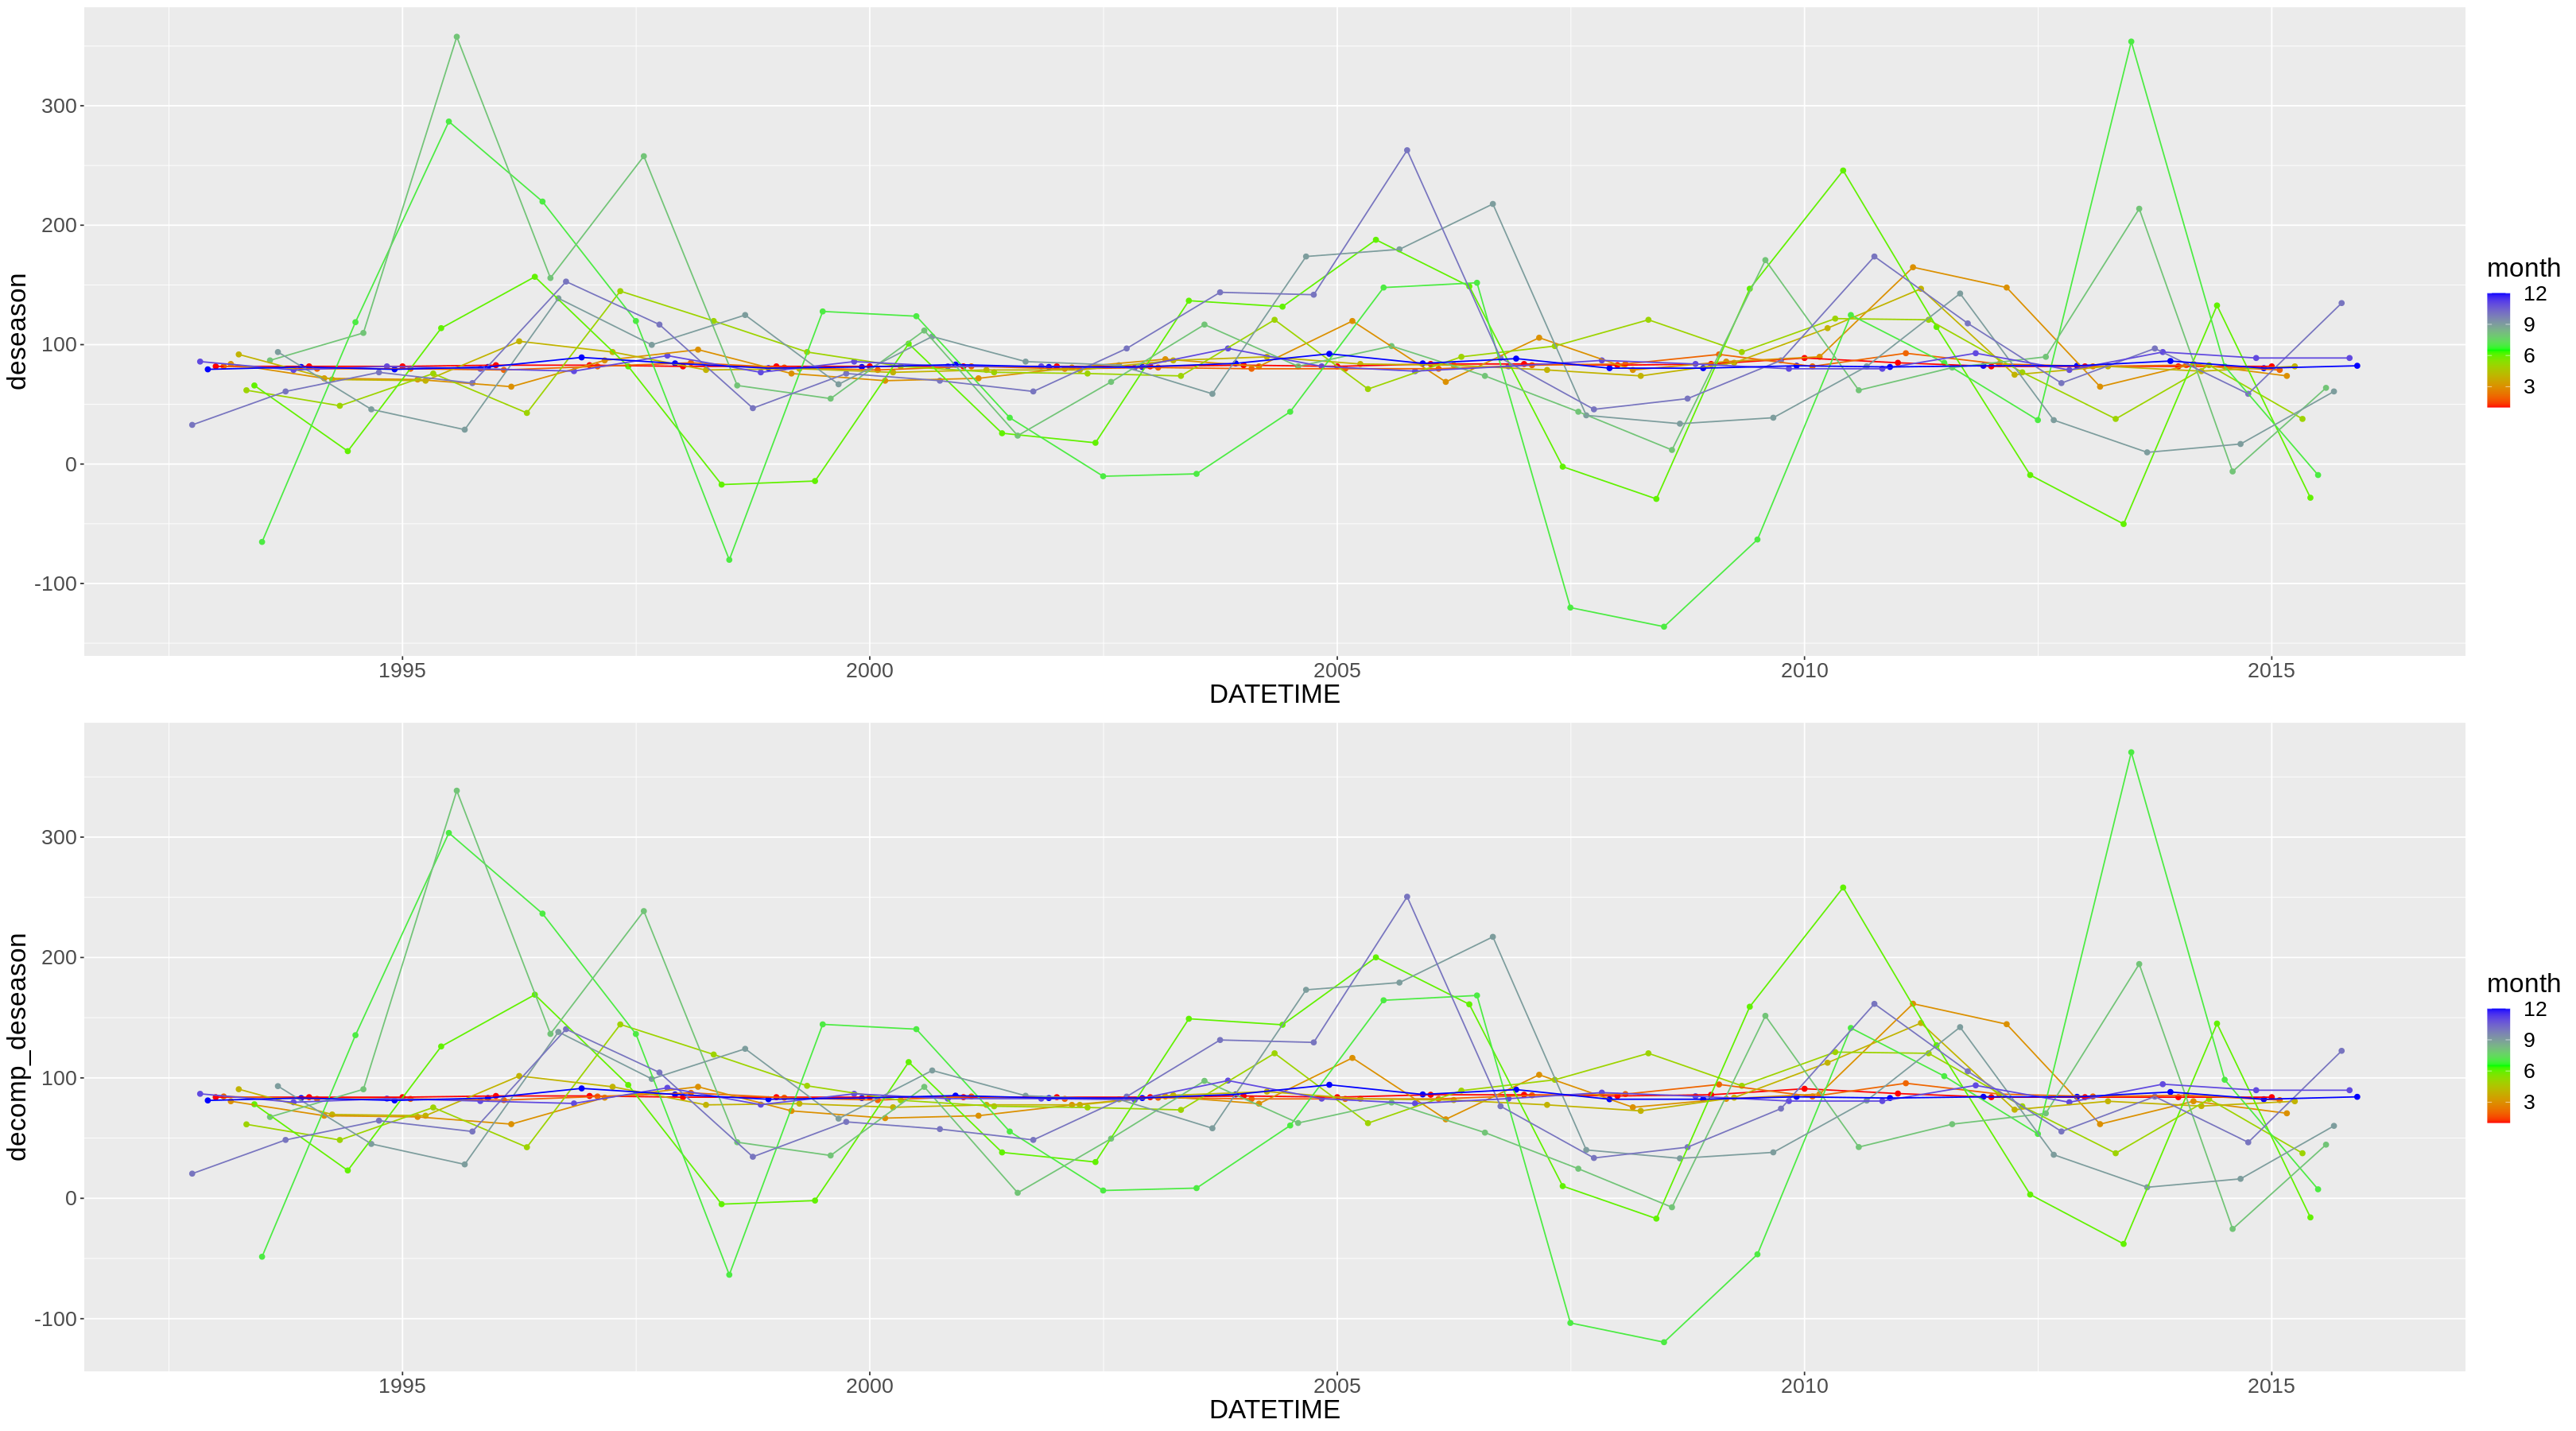

In [11]:
comps_median <- ggplot2::ggplot(moth_full, aes(x = DATETIME, y = deseason, group=month, color=month) ) +
    geom_point() +
    geom_line() +
    scale_color_gradientn(colours = rainbow(3)) + 
    theme(text = element_text(size = 20))

comps_decomp <- ggplot2::ggplot(moth_full, aes(x = DATETIME, y = decomp_deseason, group=month, color=month) ) +
    geom_point() +
    geom_line() +
    scale_color_gradientn(colours = rainbow(3)) + 
    theme(text = element_text(size = 20))

gridExtra::grid.arrange(comps_median,
                        comps_decomp,
                        ncol=1)

# Plot the deseasonalised values

Conclusion, they look very similar...

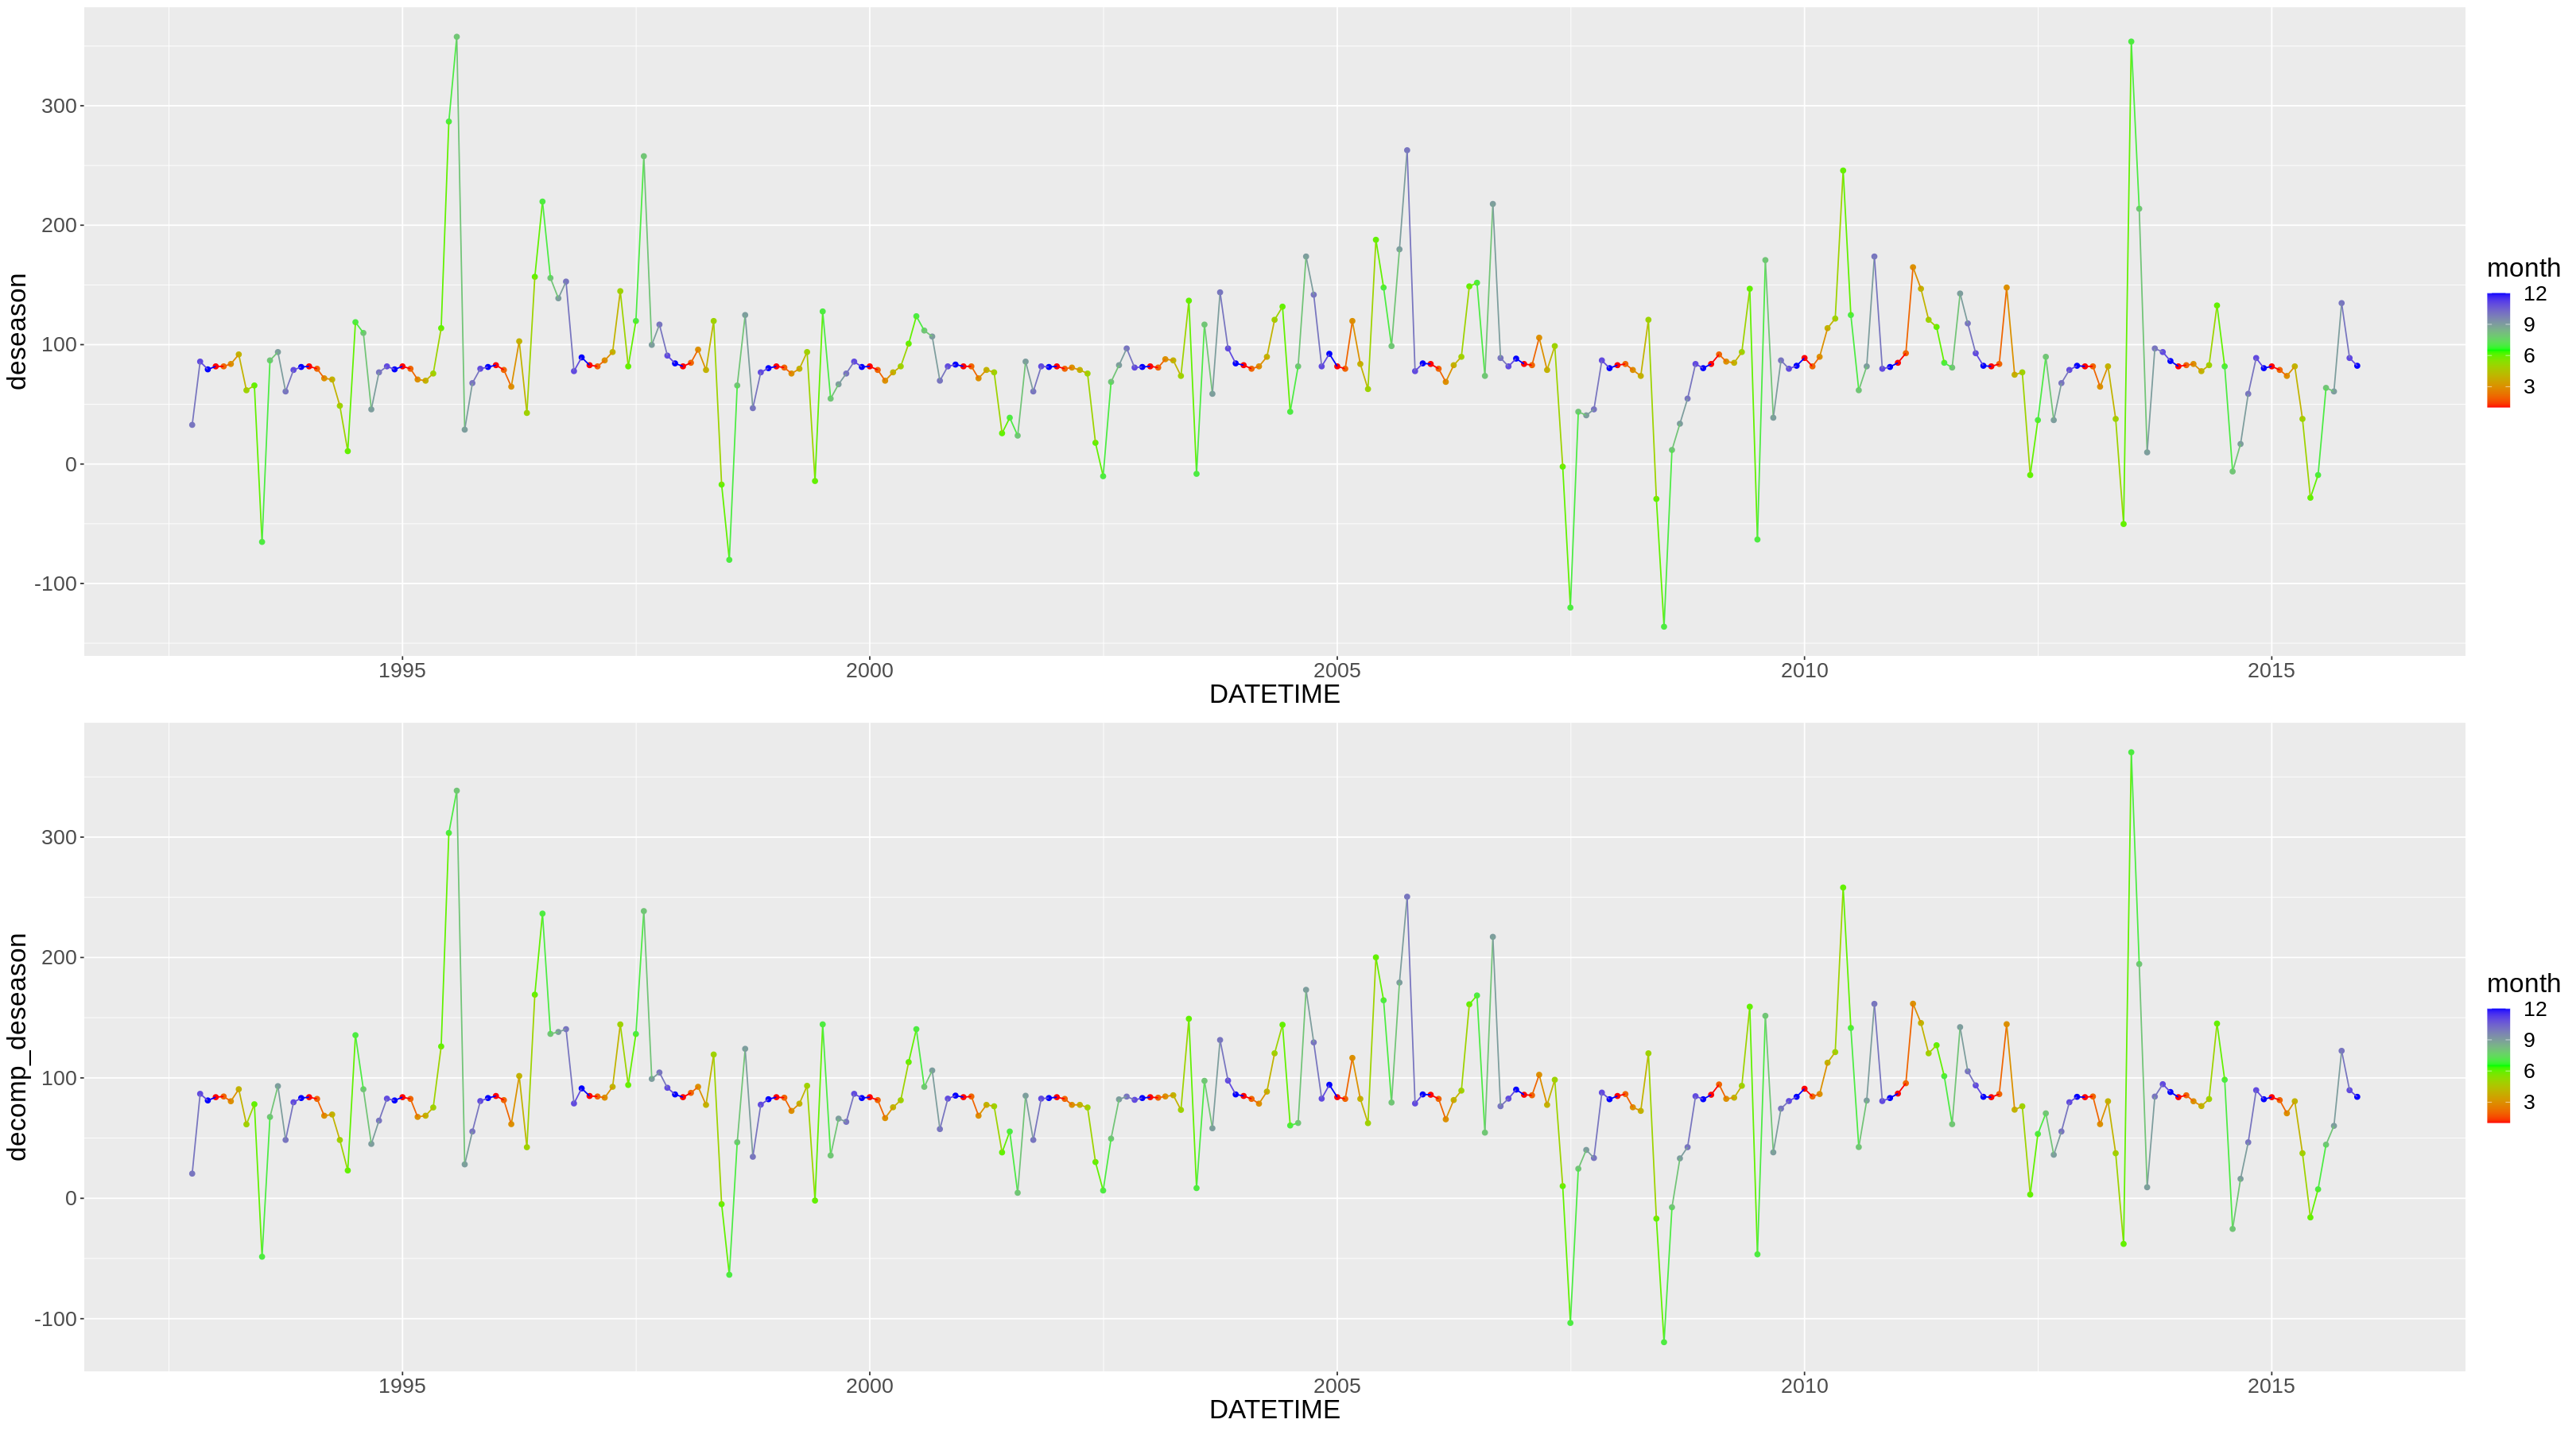

In [12]:
deseas_median <- ggplot2::ggplot(moth_full, aes(x = DATETIME, y = deseason, color=month) ) +
    geom_point() +
    geom_line() +
    scale_color_gradientn(colours = rainbow(3)) + 
    theme(text = element_text(size = 20))

deseas_decomp <- ggplot2::ggplot(moth_full, aes(x = DATETIME, y = decomp_deseason, color=month) ) +
    geom_point() +
    geom_line() +
    scale_color_gradientn(colours = rainbow(3)) + 
    theme(text = element_text(size = 20))

gridExtra::grid.arrange(deseas_median,
                        deseas_decomp,
                        ncol=1)

# Investigate how well the seasonality has been removed with a periodogram

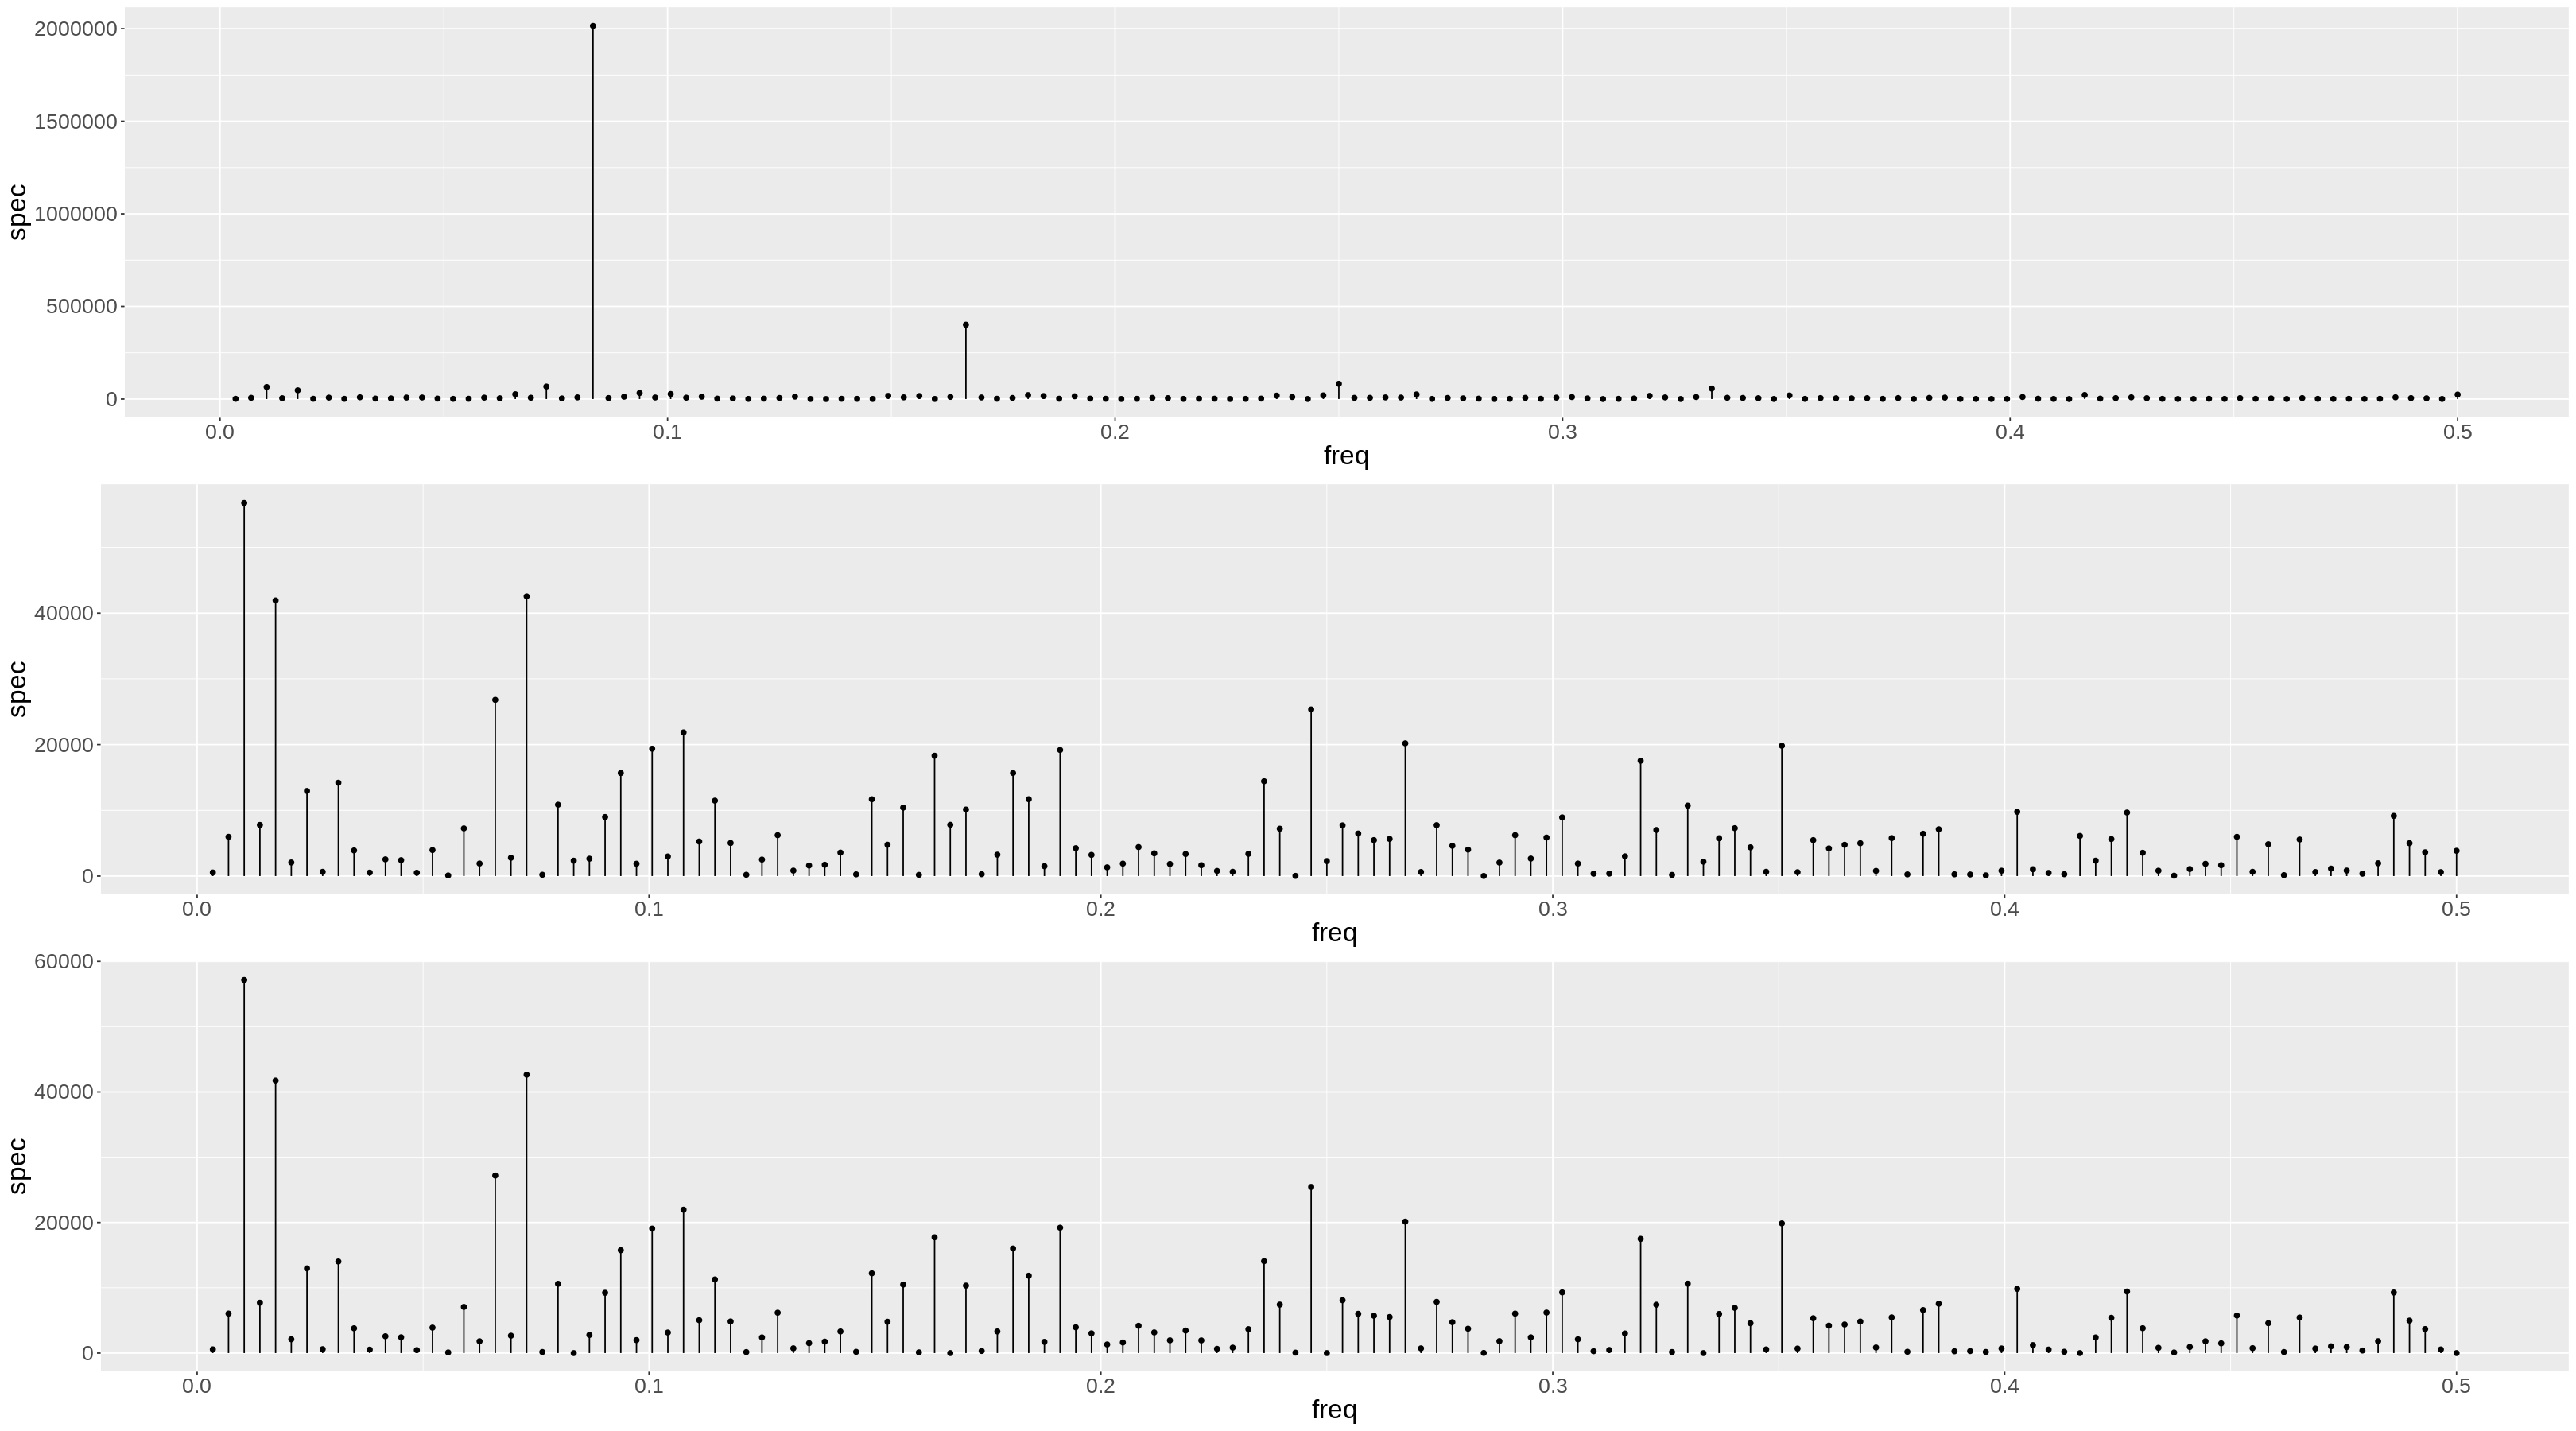

In [13]:
periodograms <- list()
for( name in c("counts", "deseason", "decomp_deseason") )
{
    periodograms[[name]] <- as.data.frame(TSA::periodogram(moth_full[,name], plot=FALSE)[1:2])
}

periodogram_counts <- 
    ggplot(periodograms$counts, aes(x = freq, y = spec) ) +
    geom_point() +
    geom_linerange(aes(x=freq, ymax=spec, ymin=0)) + 
    theme(text = element_text(size = 20))
periodogram_deseason <- 
    ggplot(periodograms$deseason, aes(x = freq, y = spec) ) +
    geom_point() +
    geom_linerange(aes(x=freq, ymax=spec, ymin=0)) + 
theme(text = element_text(size = 20))
periodogram_decomp_deseason <- 
    ggplot(periodograms$decomp_deseason, aes(x = freq, y = spec) ) +
    geom_point() +
    geom_linerange(aes(x=freq, ymax=spec, ymin=0)) + 
    theme(text = element_text(size = 20))

gridExtra::grid.arrange(periodogram_counts,
                        periodogram_deseason,
                        periodogram_decomp_deseason,
                        ncol=1)
